## Notebook to Fit Triple / Quad Models with Astrometry+RV

In [1]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,triple_model,triple_model_combined,triple_model_vlti_combined,quad_model,quad_model_combined,triple_model_vlti
from orbit_plotting import orbit_model,triple_orbit_model,quad_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *

import emcee
import corner
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [2]:
def cart2pol(x,y):
    x=-x
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x) * 180 / np.pi
    if theta>0 and theta<90:
        theta_new = theta+270
    if theta>90 and theta<360:
        theta_new = theta-90
    if theta<0:
        theta_new = 270+theta
    if np.isnan(theta):
        theta_new=theta
    return(r,theta_new)

In [3]:
###########################################
## SETUP PATHS
###########################################

if os.getcwd()[7:14] == 'tgardne':
    ## setup paths for user
    path = '/Users/tgardne/ARMADA_orbits'
    path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
    path_wds = '/Users/tgardne/wds_targets'
    path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'
    
elif os.getcwd()[7:19] == 'adam.scovera':
    ## Adam's path
    path = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/ARMADA_orbits'
    path_etalon = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/etalon_factors_fit.txt'
    path_wds = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/wds_targets'
    path_orb6 = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/orb6orbits.sql.txt'

## Read in Data:

In [4]:
###########################################
## Specify Target
###########################################
target_hd = '5143'
note = 'rv2'

#emethod = input('bootstrap errors? (y/n) ')
emethod = 'n'

query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

try:
    print(target_wds)
except:
    print('No WDS number queried')
    target_wds = input('Enter WDS: ')

HIP 4176
WDS 00533+0405
00533+0405


In [5]:
###########################################
## Read in ARMADA data
###########################################
if emethod == 'y':
    print('reading bootstrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

## Read in RV data
file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))
weight_rv = float(input('Err for RV [1 km/s]: '))
t_rv,rv,err_rv = read_rv(file_rv,weight_rv)
file_rv.close()

reading chi2 errors


Err for RV [1 km/s]:  1
MJD? (y,[n]):  n


In [6]:
### correct PAs based on precession (only for WDS):
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [7]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon = input('Apply etalon correction? (y/n) ')

## FIXME: make it easier to choose vlti data
vlti = input('Add indices for vlti (y/n)? ')
#vlti = 'y'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
    
    vlti_mask = np.ones(len(t),dtype=bool)
    vlti_mask[vlti_idx] = False
else:
    vlti_idx = np.array([])

if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

Closest factor for 58669.4243 is 22.354105845442973 days away
Closest factor for 58716.3296 is 13.286658308890765 days away
Closest factor for 58753.1807 is 2.138650522225362 days away
Closest factor for 58814.1232 is 14.097078644779685 days away
Closest factor for 58816.1237 is 16.09757864477433 days away
Closest factor for 58844.0715 is 8.05558555501193 days away
Closest factor for 59188.1122 is 8.126407408897649 days away
Closest factor for 59439.3449 is 3.811409747453581 days away
Closest factor for 59461.2839 is 17.35766808460903 days away
Closest factor for 59463.3538 is 15.287768084614072 days away
Closest factor for 59468.2862 is 10.355368084608926 days away
Closest factor for 59473.2581 is 5.383468084612105 days away
Closest factor for 59477.2164 is 1.4251680846136878 days away
Closest factor for 59488.2145 is 3.633060341118835 days away
Closest factor for 59489.2414 is 4.659960341115948 days away
Closest factor for 59501.154 is 16.572560341119242 days away
Closest factor for 

Apply etalon correction? (y/n)  n
Add indices for vlti (y/n)?  n


No etalon correction applied


## Run below cell for WDS file read-in

Number of WDS data points = 52


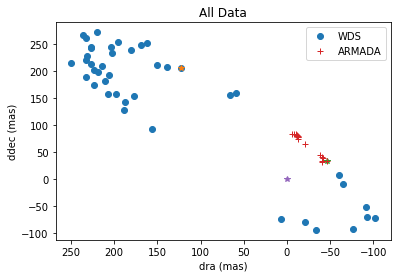

Flip WDS data? (y/n):  n


In [8]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'y'
if input_wds == 'y':
    file=open(os.path.expanduser("%s/HD%s_chi2err/HD_%s_wds.txt"%(path,target_hd,target_hd)))
    weight = 1
    t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
    print('Number of WDS data points = %s'%len(p_wds))

    ## correct WDS for PA
    #theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    idx = np.argmin(t)

    plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
    plt.plot(xpos_wds[0],ypos_wds[0],'*')
    plt.plot(xpos[idx],ypos[idx],'*')
    if len(vlti_idx)>0:
        plt.plot(xpos[vlti_mask],ypos[vlti_mask],'+',label='ARMADA-CHARA')
        plt.plot(xpos[vlti_idx],ypos[vlti_idx],'+',label='ARMADA-VLTI')
    else:
        plt.plot(xpos,ypos,'+',label='ARMADA')
    plt.plot(0,0,'*')
    plt.gca().invert_xaxis()
    plt.title('All Data')
    plt.xlabel('dra (mas)')
    plt.ylabel('ddec (mas)')
    plt.legend()
    plt.show()

    flip = input('Flip WDS data? (y/n): ')
    if flip=='y':
        xpos_wds=-p_wds*np.sin(theta_wds)
        ypos_wds=-p_wds*np.cos(theta_wds)
        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        plt.plot(xpos[idx],ypos[idx],'*')
        plt.plot(xpos,ypos,'+',label='ARMADA')
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        better = input('Flip data back to original? (y/n): ')
        if better=='y':
            xpos_wds=p_wds*np.sin(theta_wds)
            ypos_wds=p_wds*np.cos(theta_wds)
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

In [9]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6. Will need to enter your own.')

self_params = 'n'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
233.0 57.78 0.419 74.3 357.9 222.4 56113.20992200007
--------------------------


In [10]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

if vlti=='y':
    vlti_mask_all = np.ones(len(t_all),dtype=bool)
    vlti_mask_all[vlti_idx] = False

## Fit Outer Binary

In [11]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 84
    # variables        = 7
    chi-square         = 75.0131504
    reduced chi-square = 0.97419676
    Akaike info crit   = 4.49511761
    Bayesian info crit = 21.5108352
[[Variables]]
    w:           356.171391 +/- 2.64746135 (0.74%) (init = 357.9)
    bigw:        222.112129 +/- 0.59427328 (0.27%) (init = 222.4)
    inc:         73.6278047 +/- 0.78322540 (1.06%) (init = 74.3)
    e:           0.43024537 +/- 0.00566541 (1.32%) (init = 0.419)
    a:           232.599358 +/- 1.78175667 (0.77%) (init = 233)
    P:           21662.4392 +/- 205.166445 (0.95%) (init = 21089.7)
    T:           56087.1902 +/- 104.484941 (0.19%) (init = 56113.21)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, T)      =  0.941
    C(w, bigw)   = -0.713
    C(bigw, T)   = -0.624
    C(w, P)      = -0.544
    C(e, a)      = -0.444
    C(e, P)      =  0.439
    C

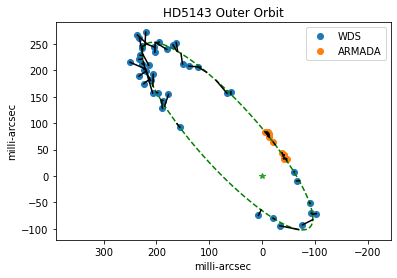

In [12]:
params = Parameters()
params.add('w',   value= omega, min=0)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_wds,ypos_wds,t_wds,error_maj_wds,error_min_wds,error_pa_wds)

----------
chi2 armada = 342.69571802627513
----------


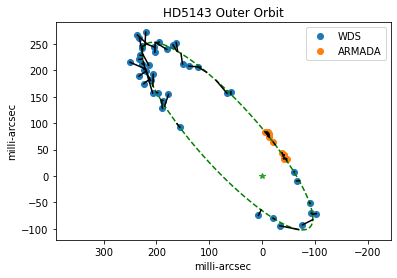

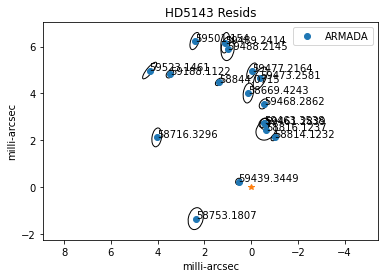

----------
Mean residual = 4559.33 micro-as
----------


In [13]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle, d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

## Run below cell for TRIPLE + RV1 Fit:

In [14]:
## Try a quad fit -- giving two orbital periods
## Do a fit at best period

P2_best = []
a2_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []

P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_best = []
gamma_best = []

include_rv = 'n'
circular = 'n'

P2_guess = 2.03
i2_guess = 90
a2_guess = 0.17

K_guess = 18.4
gamma_guess = -7.5

for i in tqdm(np.arange(50)):
    bigw2 = random.uniform(0,360)
    T2 = random.uniform(min(t)-P2_guess,max(t)+P2_guess)
    if i2_guess == 'n':
        inc2 = random.uniform(0,180)
    else:
        inc2 = i2_guess
        
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
        
    params = Parameters()
    params.add('w',   value = omega, min=0, max=360)
    params.add('bigw', value = bigomega, min=0, max=360)
    params.add('inc', value = inc, min=0, max=180)
    params.add('e', value = e, min=0, max=0.99)
    params.add('a', value = a, min=0)
    params.add('P', value = P, min=0)
    params.add('T', value = T, min=0)

    if circular!='y':
        params.add('w2',   value= w2, min=0, max=360)
        params.add('e2', value= e2, min=0,max=0.99)
    else:
        params.add('w2',   value= 0, vary=False)
        params.add('e2', value= 0, vary=False)
        
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= a2_guess, min=0)
    params.add('P2', value= P2_guess, min=0)
    params.add('T2', value= T2, min=0)

    if include_rv=='y':
        params.add('K', value= K_guess, min=0)
        params.add('gamma', value= gamma_guess)
    else:
        params.add('K', value= K_guess, vary=False)
        params.add('gamma', value= gamma_guess, vary=False)
    
    if len(vlti_idx)>0:
        params.add('mirc_scale', value=1)
    else:
        params.add('mirc_scale',value=1,vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])

    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])

    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)
    
    K_best.append(result.params['K'])
    gamma_best.append(result.params['gamma'])

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


In [15]:
P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)

P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

K_best = np.array(K_best)
gamma_best = np.array(gamma_best)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]

P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
mirc_scale_best = mirc_scale_best[idx]

K_best = K_best[idx]
gamma_best = gamma_best[idx]

In [16]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

if include_rv=='y':
    params.add('K', value= K_best, min=0)
    params.add('gamma', value= gamma_best)
else:
    params.add('K', value= K_best,vary=False)
    params.add('gamma', value= gamma_best,vary=False)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if len(vlti_idx)>0:
    minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                        error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                        error_pa_all[vlti_mask_all],
                                                        xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                        error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                        error_pa_all[vlti_idx],rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()
else:
    minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                        error_maj_all,error_min_all,
                                                        error_pa_all,rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 190
    # variables        = 14
    chi-square         = 12866.6660
    reduced chi-square = 73.1060566
    Akaike info crit   = 828.920517
    Bayesian info crit = 874.378854
[[Variables]]
    w:           356.434686 +/- 6.51274334 (1.83%) (init = 356.4347)
    bigw:        222.216907 +/- 1.70444605 (0.77%) (init = 222.2169)
    inc:         73.0845335 +/- 1.90944504 (2.61%) (init = 73.08453)
    e:           0.43251718 +/- 0.03595531 (8.31%) (init = 0.4325172)
    a:           224.844600 +/- 12.7739867 (5.68%) (init = 224.8446)
    P:           21625.0187 +/- 1078.53660 (4.99%) (init = 21625.02)
    T:           56088.7996 +/- 410.656171 (0.73%) (init = 56088.8)
    w2:          83.0461015 +/- 5.35627852 (6.45%) (init = 83.0461)
    e2:          0.98989142 +/- 0.01061761 (1.07%) (init = 0.9898914)
    bigw2:       213.368774 +/- 19.1236131 (8.96%) (init = 213.3688)
    inc2:      

In [17]:
## scale errors based on chi2
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    resids_chara = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],[],[],[],[],[],[])
    resids_vlti = triple_model_vlti(result.params,[],[],[],[],[],[],xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_chara = 2*sum(~np.isnan(xpos[vlti_mask]))
    ndata_vlti = 2*sum(~np.isnan(xpos[vlti_idx]))
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-17)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-17)
    except:
        pass
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-19)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-19)
    except:
        pass
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

try:
    print('-'*10)
    print('chi2 chara = %s'%chi2_chara)
    print('-'*10)
    
    print('-'*10)
    print('chi2 vlti = %s'%chi2_vlti)
    print('-'*10)
except:
    pass

----------
chi2 armada = 95.84261460943796
----------
----------


In [ ]:
1/np.sqrt(0.6)

In [ ]:
## scale errors
armada_scale = 1
vlti_scale = 2
chara_scale = 1

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
else:
    error_maj/=armada_scale
    error_min/=armada_scale
    error_maj_all[:len(error_maj)]/=armada_scale
    error_min_all[:len(error_maj)]/=armada_scale

In [ ]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

params.add('K', value= K_best, min=0)
params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if len(vlti_idx)>0:
    minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                        error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                        error_pa_all[vlti_mask_all],
                                                        xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                        error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                        error_pa_all[vlti_idx],rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()
else:
    minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                        error_maj_all,error_min_all,
                                                        error_pa_all,rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()

report_fit(result)

P2_best = result.params['P2'].value
a2_best = result.params['a2'].value
e2_best = result.params['e2'].value
w2_best = result.params['w2'].value
bigw2_best = result.params['bigw2'].value
inc2_best = result.params['inc2'].value
T2_best = result.params['T2'].value

P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
mirc_scale_best = result.params['mirc_scale'].value

K_best = result.params['K'].value
gamma_best = result.params['gamma'].value

In [ ]:
##########################################
## Save Plots for Triple
##########################################
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
else:
    scale=float(input('scale errors by: '))

tmodel = np.linspace(t_all[0],t_all[0]+P,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Plot RV results:
foldtime= foldAt(t_rv,P2_best,T0=T2_best)
tt=np.linspace(T2_best,T2_best+P2_best*0.99,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
w_rv = (w2_best+180)*np.pi/180
f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))
y1=K_best*(np.cos(w_rv+f)+e2_best*np.cos(w_rv))+gamma_best
tt_fold=foldAt(tt,P2_best,T0=T2_best)

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_triple_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Mass / Orbit Information

#mratio_err = ufloat(mratio.value,mratio.stderr)
#a1_err = ufloat(a1.value,a1.stderr)

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

a2_err = ufloat(result.params['a2'].value,result.params['a2'].stderr)
P2_err = ufloat(result.params['P2'].value,result.params['P2'].stderr)
T2_err = ufloat(result.params['T2'].value,result.params['T2'].stderr)
e2_err = ufloat(result.params['e2'].value,result.params['e2'].stderr)
w2_err = ufloat(result.params['w2'].value,result.params['w2'].stderr)
bigw2_err = ufloat(result.params['bigw2'].value,result.params['bigw2'].stderr)
inc2_err = ufloat(result.params['inc2'].value,result.params['inc2'].stderr)

K_err = ufloat(result.params['K'].value,result.params['K'].stderr)
gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
plx_hip = ufloat(0.01849,0.00135)
#plx_gaia = ufloat(0.01496,0.00053)

## Radial Velocity parameters included
semi1 = P2_err*24*60*60*K_err*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
print(semi1)
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
d_rv = semi1 / (a2_err/1000)
#d_rv = semi1 / ((a2_err - a1_err)/1000)

print('Distance from HIP = ')
print(1/plx_hip)
#print('Distance from GAIA = %s pc'%(1/plx_gaia))
print('Distance from RV = ')
print(d_rv)

#d_err = 1/plx_hip
d_err = d_rv

#print(K2_err/K1_err)

In [ ]:
P_err.std_dev

In [ ]:
print('%s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s'%(target_hd,P_err.nominal_value,
                                                                                                             P_err.std_dev,a_err.nominal_value,
                                                                                                             a_err.std_dev,e_err.nominal_value,
                                                                                                             e_err.std_dev,inc_err.nominal_value,
                                                                                                             inc_err.std_dev,w_err.nominal_value,
                                                                                                             w_err.std_dev,bigw_err.nominal_value,
                                                                                                             bigw_err.std_dev,T_err.nominal_value,
                                                                                                             T_err.std_dev,))
print('%s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s'%(target_hd,P2_err.nominal_value,
                                                                                                             P2_err.std_dev,a2_err.nominal_value,
                                                                                                             a2_err.std_dev,e2_err.nominal_value,
                                                                                                             e2_err.std_dev,inc2_err.nominal_value,
                                                                                                             inc2_err.std_dev,w2_err.nominal_value,
                                                                                                             w2_err.std_dev,bigw2_err.nominal_value,
                                                                                                             bigw2_err.std_dev,T2_err.nominal_value,
                                                                                                             T2_err.std_dev,K_err.nominal_value,
                                                                                                             K_err.std_dev,gamma_err.nominal_value,
                                                                                                             gamma_err.std_dev,))

In [ ]:
print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2+M3 = %s Msun'%sum1)

print('-'*10)
minner_tot = sum1-1.59
print('M1+M2=',minner_tot)

print('-'*10)
mratio = (minner_tot*(P2_err/365.25)**2)**(1/3)/d_err/(a2_err/1000) - 1
print('M2/M1=', mratio)

print('-'*10)
m1 = minner_tot / (1+1/mratio)
m2 = minner_tot - m1
print('M1=', m1)
print('M2=', m2)

In [ ]:
ainner = ((P2_err/365.25)**2 * (minner_tot))**(1/3)
aouter = ((P_err/365.25)**2 * (sum1))**(1/3)
print('a_inner = %s au'%ainner)
print('a_outer = %s au'%aouter)

print(' ')

mutual_inc1 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err+180)*np.pi/180))
mutual_inc2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))

print("Mutual Inclination = ", mutual_inc1*180/np.pi, 'OR', mutual_inc2*180/np.pi)

## Run Cell Below for a Quad + RV1 Fit

In [18]:
## Try a quad fit -- giving two orbital periods
## Do a fit at best period

## NOTE: RV goes with component 2

P2_best = []
a2_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []

P3_best = []
a3_best = []
e3_best = []
w3_best = []
bigw3_best = []
inc3_best = []
T3_best = []

P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_best = []
gamma_best = []

circular = 'y'
fit_rv = 'y'
P2_guess = 6
P3_guess = 164

for i in tqdm(np.arange(50)):
    bigw2 = random.uniform(0,360)
    T2 = random.uniform(max(t)-P2_guess,max(t))
    inc2 = random.uniform(0,180)
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
        
    params = Parameters()
    params.add('w',   value = omega, min=0)
    params.add('bigw', value = bigomega, min=0, max=360)
    params.add('inc', value = inc, min=0, max=180)
    params.add('e', value = e, min=0, max=0.99)
    params.add('a', value = a, min=0)
    params.add('P', value = P, min=0)
    params.add('T', value = T, min=0)

    if circular!='y':
        params.add('w2',   value= w2, min=0, max=360)
        params.add('e2', value= e2, min=0,max=0.99)
    else:
        params.add('w2',   value= 0, vary=False)
        params.add('e2', value= 0, vary=False)
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= 0.2, min=0)
    params.add('P2', value= P2_guess, min=0)
    params.add('T2', value= T2, min=0)
    
    params.add('w3', value=317, min=0, max=360)
    params.add('e3', value=0.1, min=0, max=0.99)
    params.add('bigw3', value= 3, min=0, max=360)
    params.add('inc3', value= 32, min=0, max=180)
    params.add('a3', value= 3, min=0)
    params.add('P3', value= P3_guess, min=0)
    params.add('T3', value= 59484, min=0)
    
    if fit_rv=='y':
        params.add('K', value= 18)
        params.add('gamma', value= -7.5)

    if len(vlti_idx)>0:
        params.add('mirc_scale', value= 1.0)
    else:
        params.add('mirc_scale', value= 1.0, vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    if fit_rv=='y':
        minner = Minimizer(quad_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                           error_maj_all,error_min_all,
                                                           error_pa_all,rv,t_rv,err_rv),
                          nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(quad_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                           error_maj_all,error_min_all,
                                                           error_pa_all),
                          nan_policy='omit')
        result = minner.minimize() 
    
    P3_best.append(result.params['P3'])
    a3_best.append(result.params['a3'])
    e3_best.append(result.params['e3'])
    w3_best.append(result.params['w3'])
    bigw3_best.append(result.params['bigw3'])
    inc3_best.append(result.params['inc3'])
    T3_best.append(result.params['T3'])

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])

    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])

    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)
    
    if fit_rv=='y':
        K_best.append(result.params['K'])
        gamma_best.append(result.params['gamma'])

100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


In [19]:
P3_best = np.array(P3_best)
a3_best = np.array(a3_best)
e3_best = np.array(e3_best)
w3_best = np.array(w3_best)
bigw3_best = np.array(bigw3_best)
inc3_best = np.array(inc3_best)
T3_best = np.array(T3_best)

P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)

P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

if fit_rv=='y':
    K_best = np.array(K_best)
    gamma_best = np.array(gamma_best)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]

P3_best = P3_best[idx]
a3_best = a3_best[idx]
e3_best = e3_best[idx]
w3_best = w3_best[idx]
bigw3_best = bigw3_best[idx]
inc3_best = inc3_best[idx]
T3_best = T3_best[idx]

P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
mirc_scale_best = mirc_scale_best[idx]

if fit_rv=='y':
    K_best = K_best[idx]
    gamma_best = gamma_best[idx]

In [20]:
print('chi2 = ', np.min(chi2_results))
print('P,a,e,i,w,bigw,T = ', P_best,a_best,e_best,inc_best,w_best,bigw_best,T_best)
print('P2,a2,e2,i2,w2,bigw2,T2 = ', P2_best,a2_best,e2_best,inc2_best,w2_best,bigw2_best,T2_best)
print('P3,a3,e3,i3,w3,bigw3,T3 = ', P3_best,a3_best,e3_best,inc3_best,w3_best,bigw3_best,T3_best)
print('K,gamma = ', K_best, gamma_best)

chi2 =  0.6522721056749284
P,a,e,i,w,bigw,T =  21489.740771200053 233.6382415859165 0.42859256416478025 73.39711166883913 359.75439856916637 221.157639441965 56222.575967348435
P2,a2,e2,i2,w2,bigw2,T2 =  6.0007631491108215 0.1674579159380314 0.0 179.9940925937252 0.0 242.63303654952819 59522.32229374676
P3,a3,e3,i3,w3,bigw3,T3 =  164.2695277406113 3.133282070127213 0.07458762992972187 32.68707111499258 292.94247727275604 7.529754204489785 59476.16299935274
K,gamma =  18.38663225708583 -7.5036798940190765


In [24]:
## Save a fit for errors

circular = 'y'

params = Parameters()
params.add('w',   value = w_best, min=0)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=360)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)
    
params.add('w3', value=w3_best, min=0, max=360)
params.add('e3', value=e3_best, min=0, max=0.99)
params.add('bigw3', value= bigw3_best, min=0, max=360)
params.add('inc3', value= inc3_best, min=0, max=360)
params.add('a3', value= a3_best, min=0)
params.add('P3', value= P3_best, min=0)
params.add('T3', value= T3_best, min=0)
    
if fit_rv=='y':
    params.add('K', value= K_best)
    params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value= 1.0)
else:
    params.add('mirc_scale', value= mirc_scale_best, vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if fit_rv=='y':
    minner = Minimizer(quad_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all,rv,t_rv,err_rv),
                      nan_policy='omit')
    result = minner.minimize()
else:
    minner = Minimizer(quad_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all),
                      nan_policy='omit')
    result = minner.minimize() 
    
report_fit(result)

P3_best = result.params['P3']
a3_best = result.params['a3']
e3_best = result.params['e3']
w3_best = result.params['w3']
bigw3_best = result.params['bigw3']
inc3_best = result.params['inc3']
T3_best = result.params['T3']

P2_best = result.params['P2']
a2_best = result.params['a2']
e2_best = result.params['e2']
w2_best = result.params['w2']
bigw2_best = result.params['bigw2']
inc2_best = result.params['inc2']
T2_best = result.params['T2']

P_best = result.params['P']
a_best = result.params['a']
e_best = result.params['e']
w_best = result.params['w']
bigw_best = result.params['bigw']
inc_best = result.params['inc']
T_best = result.params['T']

mirc_scale_best = result.params['mirc_scale']
chi2_results = result.redchi

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 190
    # variables        = 21
    chi-square         = 133.066910
    reduced chi-square = 0.78737816
    Akaike info crit   = -25.6726779
    Bayesian info crit = 42.5148276
[[Variables]]
    w:           359.754393 +/- 0.52068535 (0.14%) (init = 359.7544)
    bigw:        221.157582 +/- 0.11060152 (0.05%) (init = 221.1576)
    inc:         73.3971571 +/- 0.18658744 (0.25%) (init = 73.39716)
    e:           0.42859235 +/- 0.00362664 (0.85%) (init = 0.4285923)
    a:           233.638667 +/- 1.29551381 (0.55%) (init = 233.6387)
    P:           21489.7319 +/- 100.223965 (0.47%) (init = 21489.73)
    T:           56222.5749 +/- 37.3513066 (0.07%) (init = 56222.57)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       242.642217 +/- 9.70628254 (4.00%) (init = 242.6422)
    inc2:        179.994093 +/- 34706.2349 (19281.87%) (init = 179.9941)
    a2:          0.16749

In [25]:
##########################################
## See reduced chi2
##########################################
if len(vlti_idx)>0:
    resids_armada = quad_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
    resids_wds = quad_model(result.params,xpos_all[len(xpos):],ypos_all[len(xpos):],t_all[len(xpos):],error_maj_all[len(xpos):],
                                error_min_all[len(xpos):],error_pa_all[len(xpos):])
else:
    resids_armada = quad_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
    resids_wds = quad_model(result.params,xpos_all[len(xpos):],ypos_all[len(xpos):],t_all[len(xpos):],error_maj_all[len(xpos):],
                                error_min_all[len(xpos):],error_pa_all[len(xpos):])
    
ndata_armada = 2*sum(~np.isnan(xpos))
ndata_wds = 2*sum(~np.isnan(xpos_wds))
if circular=='y':
    #print(ndata_armada)
    #print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-12)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-12)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-14)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-14)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)
print('-'*10)
print('chi2 wds = %s'%chi2_wds)
print('-'*10)

----------
chi2 armada = 1.0926710149481391
----------
----------
chi2 wds = 1.0005319941853061
----------


In [23]:
## scale errors to fit again

armada_scale = 1/np.sqrt(0.2)
vlti_scale = 1
chara_scale = 1
wds_scale = 1/np.sqrt(0.95)

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(error_maj):]/=wds_scale
    error_min_all[len(error_maj):]/=wds_scale
    
else:
    error_maj/=armada_scale
    error_min/=armada_scale
    error_maj_all[:len(error_maj)]/=armada_scale
    error_min_all[:len(error_maj)]/=armada_scale
    
    #error_maj_wds/=wds_scale
    #error_min_wds/=wds_scale
    error_maj_all[len(error_maj):]/=wds_scale
    error_min_all[len(error_maj):]/=wds_scale

34
24
----------
chi2 armada = 1.4140448428740624
----------


scale errors by:  1


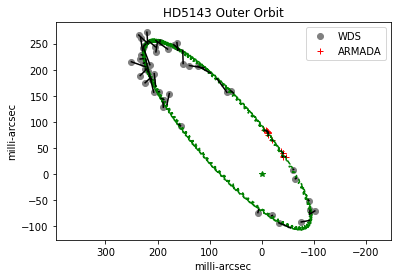

In [26]:
##########################################
## Save Plots for Quadruple
##########################################
if len(vlti_idx)>0:
    resids_armada = quad_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = quad_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))

circular = 'y'
if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
else:
    scale=float(input('scale errors by: '))

tmodel = np.linspace(t_all[0],t_all[0]+2*P,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS',color='grey')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'*', label='ARMADA-VLTI',color='red')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'+', label='ARMADA-CHARA',color='blue')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='red')
ax.plot(0,0,'*',color='g')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_outer_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

Scale for triple =  1


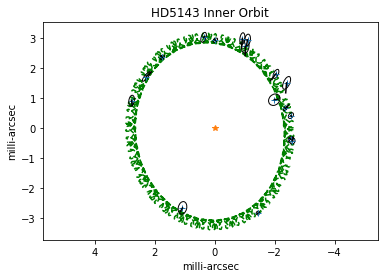

0.14005092288586624


In [27]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+4*P3_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g',zorder=0)

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black',zorder=1)
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_inner_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

resids_x = xpos_inner[:len(xpos)] - rapoints_inner[:len(xpos)]
resids_y = ypos_inner[:len(xpos)] - decpoints_inner[:len(xpos)]
resids = np.sqrt(resids_x**2 + resids_y**2)
print(np.nanmedian(resids))

Scale for triple =  1


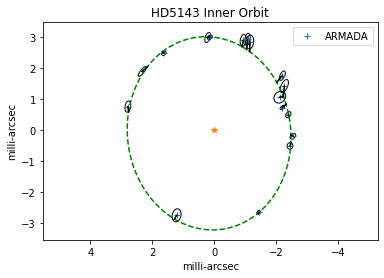

In [28]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+P3_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(a2_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t_all,tmodel)

ra_inner = ra - ra2 - ra3
dec_inner = dec - dec2 - dec3
rapoints_inner = rapoints - rapoints2 - rapoints3
decpoints_inner = decpoints - decpoints2 - decpoints3

xpos_inner = xpos_all - rapoints2 - rapoints3
ypos_inner = ypos_all - decpoints2 - decpoints3

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_inner1_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

Scale for triple =  1


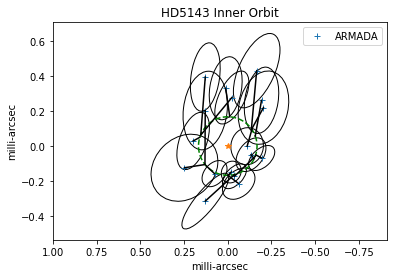

In [29]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+P2_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(a3_best,e3_best,inc3_best,
                                        w3_best,bigw3_best,P3_best,
                                        T3_best,t_all,tmodel)

ra_inner = ra - ra2 - ra3
dec_inner = dec - dec2 - dec3
rapoints_inner = rapoints - rapoints2 - rapoints3
decpoints_inner = decpoints - decpoints2 - decpoints3

xpos_inner = xpos_all - rapoints2 - rapoints3
ypos_inner = ypos_all - decpoints2 - decpoints3

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_inner2_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

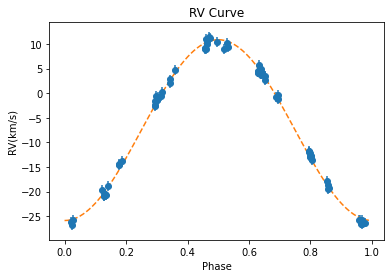

In [30]:
## Plot RV results:

foldtime= foldAt(t_rv,P2_best,T0=T2_best)
tt=np.linspace(T2_best,T2_best+P2_best*0.99,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
w_rv = (w2_best+180)*np.pi/180
f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))

if fit_rv=='n':
    K_best = 18.5
    gamma_best = -7.5

y1=K_best*(np.cos(w_rv+f)+e2_best*np.cos(w_rv))+gamma_best
tt_fold=foldAt(tt,P2_best,T0=T2_best)

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_quad_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [31]:
## print info for table
idx = t.argsort()
instrument = 'GRAVITY'

for j,k,l,m,n,o in zip(t[idx],p[idx],theta[idx]*180/np.pi,error_maj[idx],error_min[idx],error_deg[idx]):
    print('& %s & %s & %s & %s & %s & %s & %s \\\\'%(j,np.around(k,3),np.around(l,3),m,n,o,instrument))

& 58669.4243 & 56.717 & 305.263 & 0.191541582952632 & 0.09521177448194104 & 351.0974 & GRAVITY \\
& 58716.3296 & 52.646 & 309.778 & 0.18201593336848287 & 0.09069491716739148 & 350.7991 & GRAVITY \\
& 58753.1807 & 51.957 & 308.62 & 0.21278422873887998 & 0.14042506898698678 & 347.0782 & GRAVITY \\
& 58814.1232 & 57.289 & 313.697 & 0.08622278121239188 & 0.048209625594895465 & 136.7528 & GRAVITY \\
& 58816.1237 & 57.25 & 314.313 & 0.20920651997488032 & 0.17181946339108384 & 135.3994 & GRAVITY \\
& 58844.0715 & 57.796 & 319.164 & 0.0892638336617916 & 0.05250287611169506 & 132.2863 & GRAVITY \\
& 59188.1122 & 67.556 & 341.983 & 0.08582028897644192 & 0.05786943925769455 & 318.5187 & GRAVITY \\
& 59439.3449 & 74.97 & 350.167 & 0.06426459367334394 & 0.05482838680829484 & 331.8828 & GRAVITY \\
& 59461.2839 & 78.623 & 350.514 & 0.10625795029079001 & 0.09293098514489126 & 351.8227 & GRAVITY \\
& 59463.3538 & 78.766 & 350.633 & 0.10652627844808997 & 0.07302998014514313 & 312.0021 & GRAVITY \\
& 594

In [32]:
## print rv for paper
for i,j,k in zip(t_rv,rv,err_rv):
    print('& %s & %s & %s \\\\'%(i,j,k))

& 59250.1246 & 3.8 & 1.0 \\
& 59251.0955 & -12.8 & 1.0 \\
& 59252.0962 & -26.6 & 1.0 \\
& 59254.0977 & -1.4 & 1.0 \\
& 59257.1042 & -13.0 & 1.0 \\
& 59357.472 & 10.2 & 1.0 \\
& 59358.47 & -1.2 & 1.0 \\
& 59359.4705 & -19.3 & 1.0 \\
& 59362.4614 & 4.7 & 1.0 \\
& 59364.4613 & -0.3 & 1.0 \\
& 59365.4501 & -18.7 & 1.0 \\
& 59366.443 & -26.8 & 1.0 \\
& 59371.4287 & -17.9 & 1.0 \\
& 59372.4196 & -26.2 & 1.0 \\
& 59373.4198 & -13.7 & 1.0 \\
& 59375.41 & 9.0 & 1.0 \\
& 59376.4296 & -0.8 & 1.0 \\
& 59390.4683 & -25.8 & 1.0 \\
& 59391.3703 & -14.4 & 1.0 \\
& 59392.3705 & 2.8 & 1.0 \\
& 59447.2947 & 10.5 & 1.0 \\
& 59448.219 & 3.6 & 1.0 \\
& 59449.4615 & -19.4 & 1.0 \\
& 59466.2199 & 2.7 & 1.0 \\
& 59469.3725 & -14.6 & 1.0 \\
& 59470.3743 & 2.0 & 1.0 \\
& 59471.5086 & 9.4 & 1.0 \\
& 59478.1797 & 4.2 & 1.0 \\
& 59490.1813 & 4.2 & 1.0 \\
& 59494.218 & 0.3 & 1.0 \\
& 59496.1344 & 5.0 & 1.0 \\
& 59497.1447 & -13.6 & 1.0 \\
& 59501.1532 & 11.3 & 1.0 \\
& 59502.1532 & 5.0 & 1.0 \\
& 59503.1293 & -12.7 

In [28]:
a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

a2_err = ufloat(result.params['a2'].value,result.params['a2'].stderr)
P2_err = ufloat(result.params['P2'].value,result.params['P2'].stderr)
T2_err = ufloat(result.params['T2'].value,result.params['T2'].stderr)
e2_err = ufloat(result.params['e2'].value,result.params['e2'].stderr)
w2_err = ufloat(result.params['w2'].value,result.params['w2'].stderr)
bigw2_err = ufloat(result.params['bigw2'].value,result.params['bigw2'].stderr)
inc2_err = ufloat(result.params['inc2'].value,result.params['inc2'].stderr)

a3_err = ufloat(result.params['a3'].value,result.params['a3'].stderr)
P3_err = ufloat(result.params['P3'].value,result.params['P3'].stderr)
T3_err = ufloat(result.params['T3'].value,result.params['T3'].stderr)
e3_err = ufloat(result.params['e3'].value,result.params['e3'].stderr)
w3_err = ufloat(result.params['w3'].value,result.params['w3'].stderr)
bigw3_err = ufloat(result.params['bigw3'].value,result.params['bigw3'].stderr)
inc3_err = ufloat(result.params['inc3'].value,result.params['inc3'].stderr)

K_err = ufloat(result.params['K'].value,result.params['K'].stderr)
gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

In [28]:
print('%s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P_err.nominal_value,a_err.nominal_value,
                                               e_err.nominal_value,inc_err.nominal_value,
                                               w_err.nominal_value,bigw_err.nominal_value,
                                               T_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P_err.std_dev,a_err.std_dev,
                                                                                  e_err.std_dev,inc_err.std_dev,w_err.std_dev,
                                                                                  bigw_err.std_dev,T_err.std_dev,))
print('--'*10)
print('--'*10)

print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                        e2_err.nominal_value,inc2_err.nominal_value,
                                                        w2_err.nominal_value,bigw2_err.nominal_value,
                                                        T2_err.nominal_value,K_err.nominal_value,
                                                        gamma_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P2_err.std_dev,
                                                                                                a2_err.std_dev,e2_err.std_dev,
                                                                                                inc2_err.std_dev,w2_err.std_dev,
                                                                                                bigw2_err.std_dev,T2_err.std_dev,
                                                                                                K_err.std_dev,gamma_err.std_dev,))

print('--'*10)
print('--'*10)

print('%s & %s & %s & %s & %s & %s & %s & %s & -- & --'%(target_hd,P3_err.nominal_value,a3_err.nominal_value,
                                                        e3_err.nominal_value,inc3_err.nominal_value,
                                                        w3_err.nominal_value,bigw3_err.nominal_value,
                                                        T3_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & '%(P3_err.std_dev,
                                                                                        a3_err.std_dev,e3_err.std_dev,
                                                                                        inc3_err.std_dev,w3_err.std_dev,
                                                                                        bigw3_err.std_dev,T3_err.std_dev))

5143 & 21489.468500298448 & 233.6304175004086 & 0.42859823011599263 & 73.3964676314916 & 359.7558092739328 & 221.15746849628994 & 56222.70532451225
-- & $\pm$89.1550320109493 & $\pm$1.1256661706680429 & $\pm$0.003104885451238149 & $\pm$0.16084309383548442 & $\pm$0.4580171491801392 & $\pm$0.0962143538142232 & $\pm$31.98782677072844
--------------------
--------------------
5143 & 6.000647474163413 & 0.16804220975627415 & 0.0 & 179.93424848552306 & 0.0 & 241.95497491783345 & 58688.23117992204 & 18.387781083051014 & -7.507385121469004
-- & $\pm$0.0008437232193077077 & $\pm$0.025561622256636975 & $\pm$0.0 & $\pm$4083.245690956123 & $\pm$0.0 & $\pm$8.850557443036811 & $\pm$0.10996541614395065 & $\pm$0.27083365769287815 & $\pm$0.19010079850975975
--------------------
--------------------
5143 & 164.27012107092807 & 3.132917241036721 & 0.0743092701406539 & 32.693408216689264 & 292.90542305242127 & 7.558370190114555 & 59476.15463558069 & -- & --
-- & $\pm$0.10218703377161918 & $\pm$0.046891864

In [36]:
## distance from HIP/GAIA
plx_hip = ufloat(0.00794,0.00073)
plx_gaia = ufloat(0.0097025,0.0001694)

## Radial Velocity parameters included
semi1 = P3_err*24*60*60*K_err*(1-e3_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc3_err)
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
d_rv = semi1 / ((a3_err)/1000)

print('Distance from HIP = %s pc'%(1/plx_hip))
print('Distance from GAIA = %s pc'%(1/plx_gaia))
print('Distance from RV = %s pc'%d_rv)

d_err = 1/plx_gaia
#d_err = d_rv

#print(K2_err/K1_err)

Distance from HIP = 126+/-12 pc
Distance from GAIA = 103.1+/-1.8 pc
Distance from RV = (9+/-4)e+01 pc


In [37]:
print(a1_err)
print(a2_err-a1_err)

mratio_err = (a2_err - a1_err) / a1_err
print(mratio_err)

NameError: name 'a1_err' is not defined

In [38]:
## mass ratio Ba/Bb
#mratio = (a_in-a2) / a_in

print('-'*10)
print('Masses from distance')
print('-'*10)
#print('mass ratio Bb/Ba = %s'%mratio_err)

# masses
print('distance=%s pc'%d_err)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2+M3+M4 = %s Msun'%sum1)

## assume a mass
MA = 1.6
MB = 1.1

sum_new = sum1 - MA - MB

print(sum_new)

----------
Masses from distance
----------
distance=103.1+/-1.8 pc
M1+M2+M3+M4 = 4.03+/-0.22 Msun
1.33+/-0.22


In [ ]:
## hmags
hmag = ufloat(3.89,0.24)
f12 = ufloat(10.39,0.04)
f13 = ufloat(14.73,0.06)

f1 = 1 / (1+1/f12+1/f13)
f2 = f1/f12
f3 = f1/f13

print(f1,f2,f3)

h1 = hmag-2.5*umath.log(f1,10)
h2 = hmag-2.5*umath.log(f2,10)
h3 = hmag-2.5*umath.log(f3,10)

print(h1,h2,h3)

In [39]:
## mutual inclination
#i_err = ufloat(75.92,0.15)
inc2_err = ufloat(153,45)
#bigw_err = ufloat(120.19,0.28)
#bigw2_err = ufloat(131.17,0.16)

theta = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                   umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))
theta2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)-
                    umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))

theta_out = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc3_err*np.pi/180)+
                   umath.sin(inc_err*np.pi/180)*umath.sin(inc3_err*np.pi/180)*umath.cos((bigw_err-bigw3_err)*np.pi/180))
theta_out2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc3_err*np.pi/180)-
                    umath.sin(inc_err*np.pi/180)*umath.sin(inc3_err*np.pi/180)*umath.cos((bigw_err-bigw3_err)*np.pi/180))


print(theta*180/np.pi)
print(theta2*180/np.pi)

print(theta_out*180/np.pi)
print(theta_out2*180/np.pi)

(8+/-4)e+01
(1.3+/-0.4)e+02
101.0+/-1.6
47.8+/-1.6


In [ ]:
print(umath.cos((bigw_err-bigw2_err)*np.pi/180))
print(umath.cos((bigw_err-bigw2_err)*np.pi/180+np.pi))

153.0+/-45.0

## MCMC Routine

In [71]:
emcee_params = result.params.copy()
nwalkers = 2*len(emcee_params)
steps = 50000
burn = 10000
thin = 100

In [72]:
if fit_rv=='y':
    minner = Minimizer(quad_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all,rv,t_rv,err_rv),
                      nan_policy='omit')
    result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
else:
    minner = Minimizer(quad_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all),
                      nan_policy='omit')
    result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)

100%|██████████| 50000/50000 [7:02:11<00:00,  1.97it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 21 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: [2976.21120504 2401.53836429 2942.10189363 2585.36129595 2886.78039131
 2699.64523025 2983.45696379 2785.64413774 2466.3367551  2539.35011074
 2163.57784304 5185.68841459 3155.24773407 2983.29615036 2707.8805343
 2342.5963291  2299.99276678 2342.6395767  3116.18679198 2508.11191581
 2084.84579051]


In [73]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 2400000
    # data points      = 190
    # variables        = 21
    chi-square         = 134.273157
    reduced chi-square = 0.79451572
    Akaike info crit   = -23.9580940
    Bayesian info crit = 44.2294115
[[Variables]]
    w:           359.687959 +/- 0.60065609 (0.17%) (init = 359.7586)
    bigw:        221.128778 +/- 0.12930108 (0.06%) (init = 221.1607)
    inc:         73.4311355 +/- 0.21039377 (0.29%) (init = 73.39226)
    e:           0.42858792 +/- 0.00408038 (0.95%) (init = 0.4286129)
    a:           233.964685 +/- 1.43467305 (0.61%) (init = 233.5794)
    P:           21518.2917 +/- 122.750996 (0.57%) (init = 21489.12)
    T:           56215.7906 +/- 42.3523230 (0.08%) (init = 56223.01)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       241.855661 +/- 11.7429426 (4.86%) (init = 239.2245)
    inc2:        180.452315 +/- 31.3196626 (17.36%) (init = 179.9282)
    a2:          0.16256

In [74]:
chains = result.flatchain
print(chains.shape)

(19200, 21)


In [75]:
## save chains
np.save("%s/%s_%s_chains"%(directory,target_hd,note),chains)

In [76]:
## load chains
chains = np.load("%s/%s_%s_chains.npy"%(directory,target_hd,note))

ValueError: Provided figure has 441 axes, but data has dimensions K=24

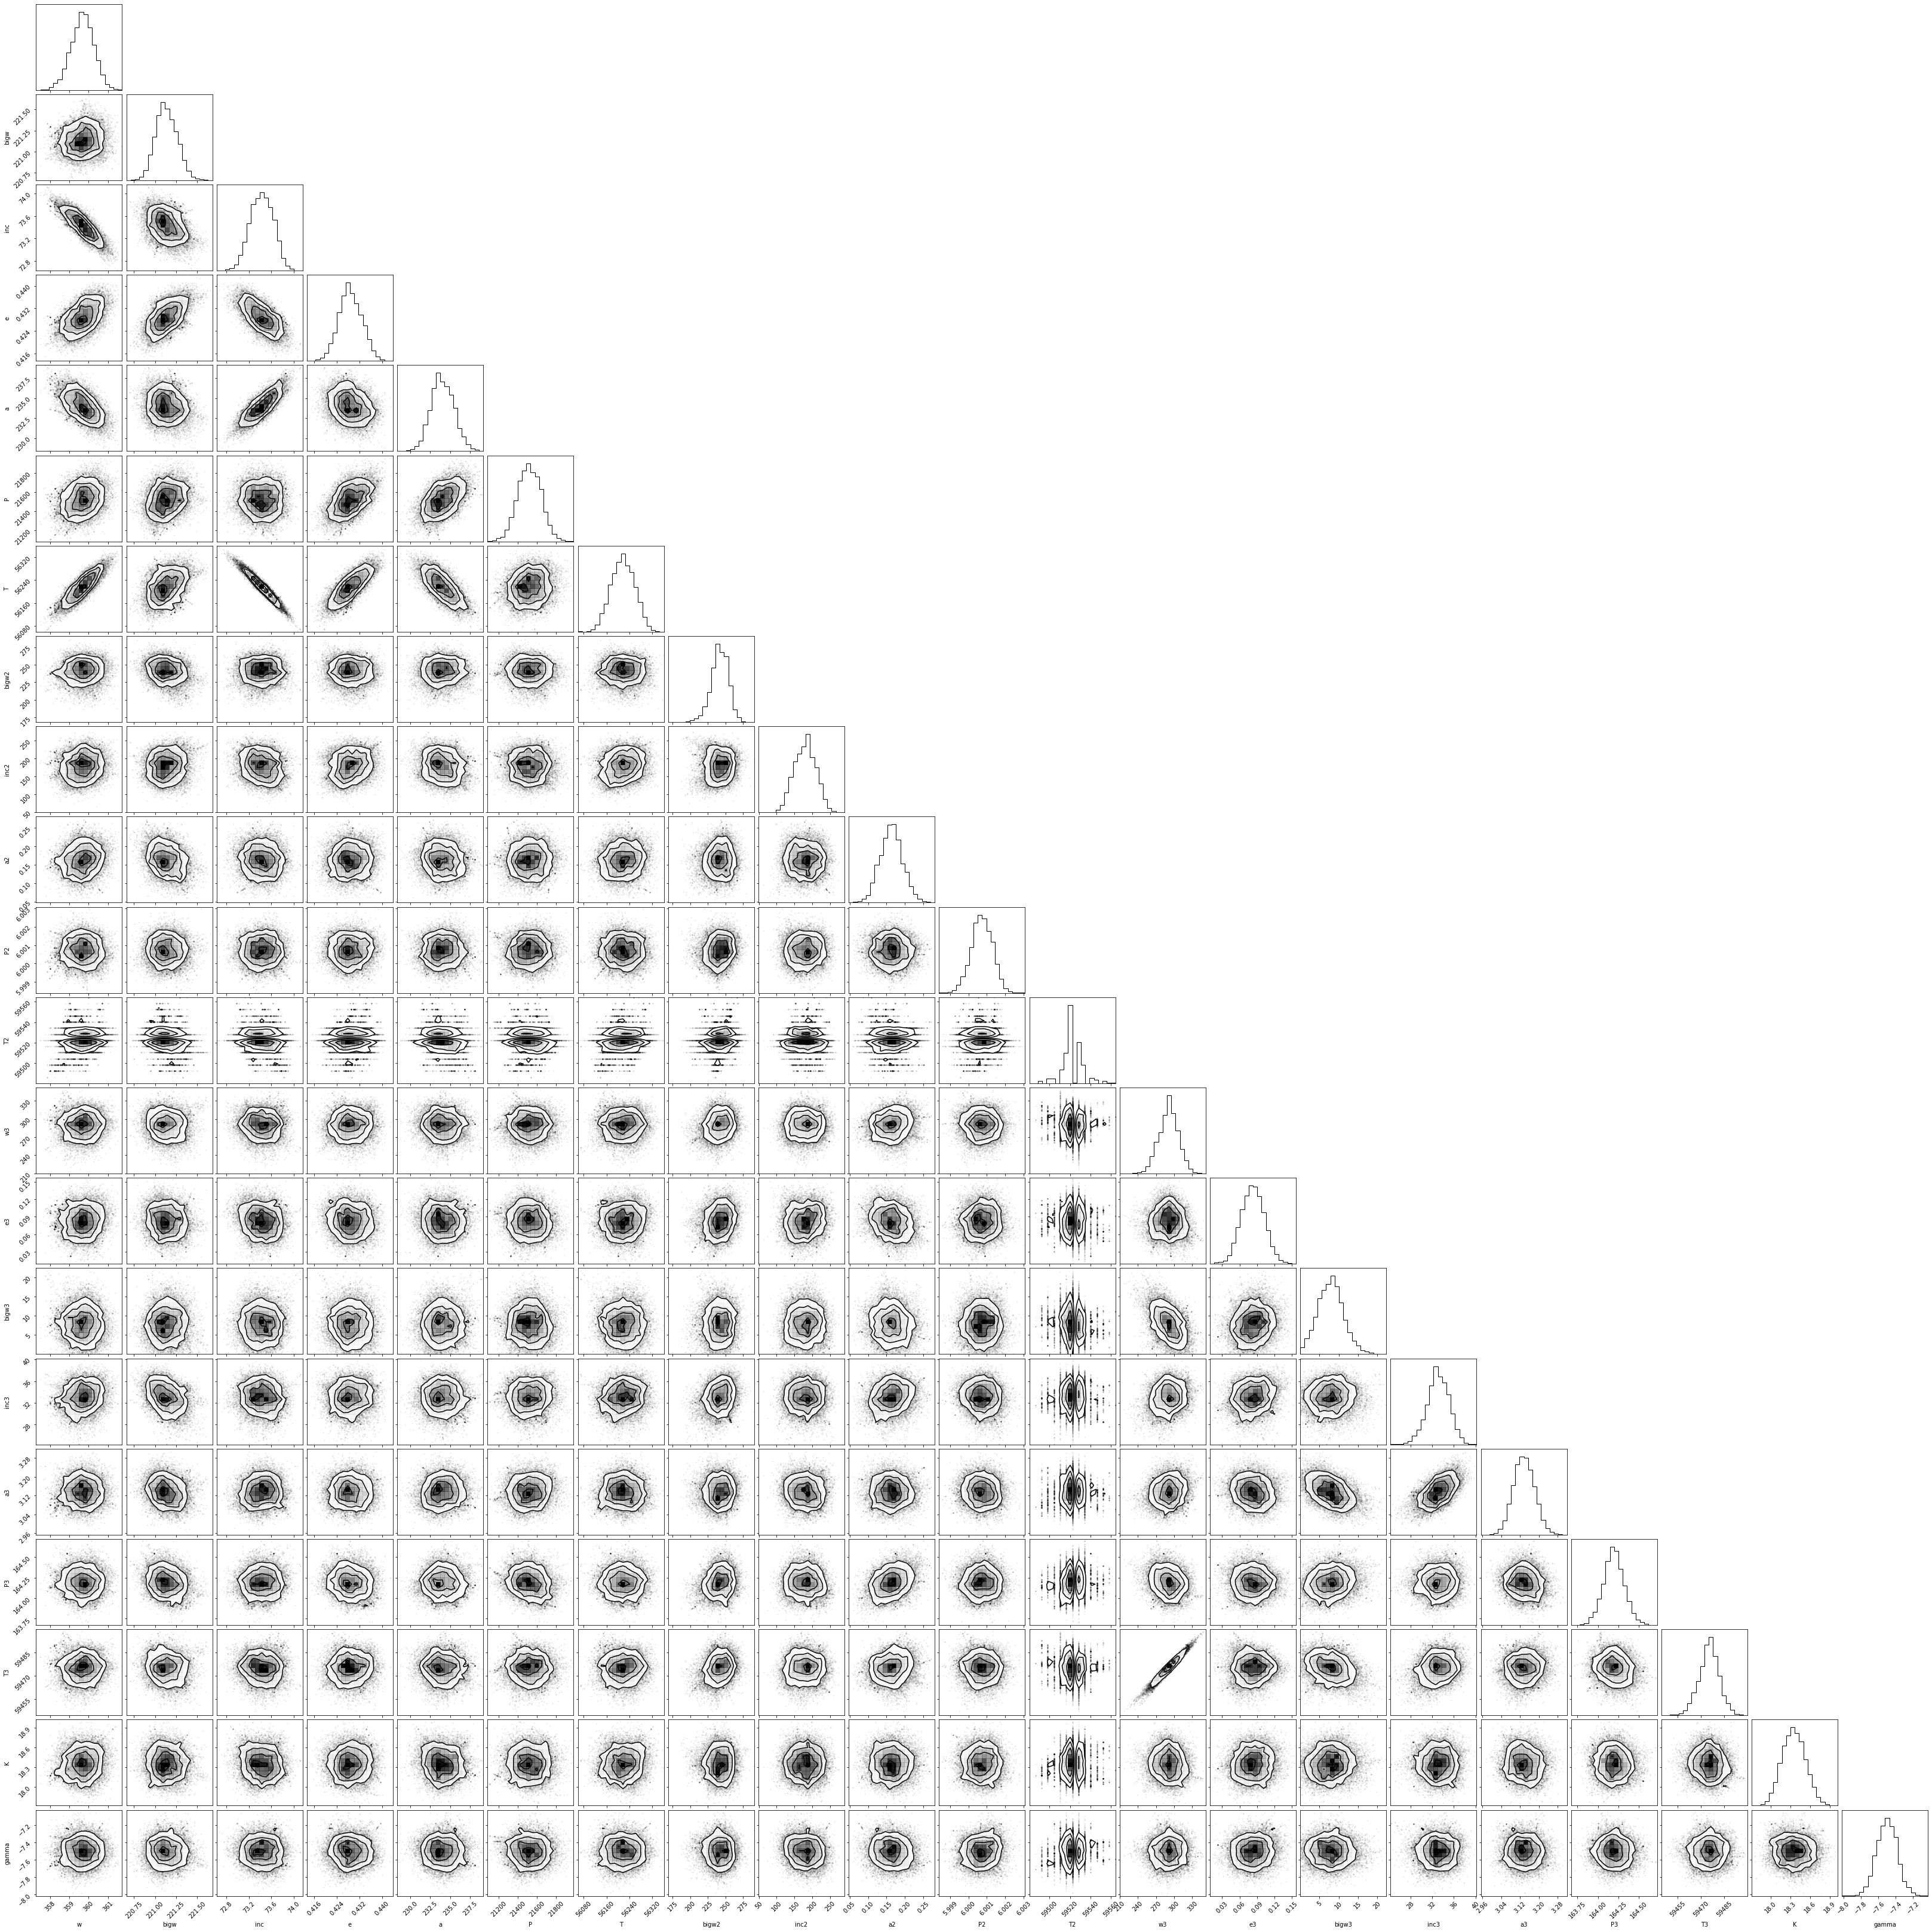

In [77]:
emcee_plot = corner.corner(result.flatchain, labels=result.var_names,
                           truths=list(result.params.valuesdict().values()))

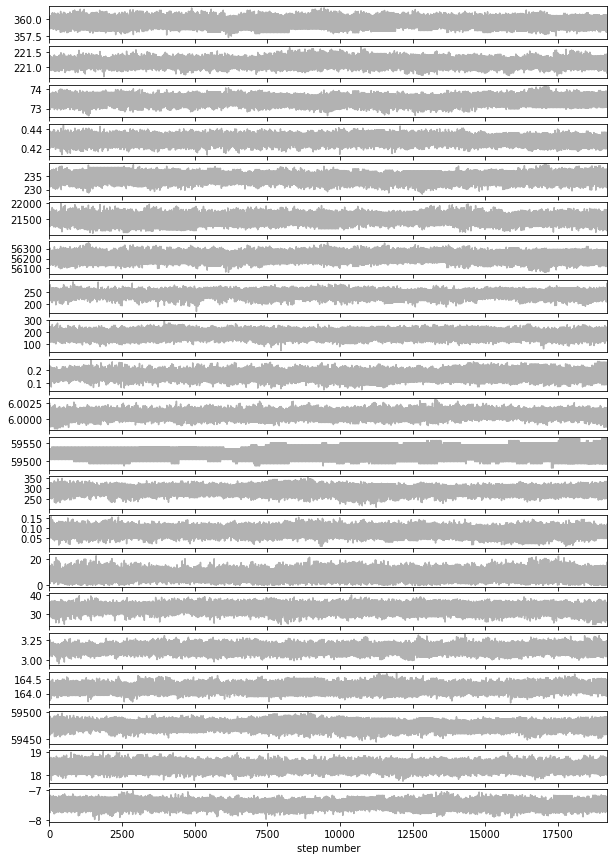

In [78]:
## look at walkers 
fig, axes = plt.subplots(21, figsize=(10, 15), sharex=True)

labels=["$\omega$ (rad)","$\Omega$ (rad)","i (rad)","e","a (mas)","P (d)","T (MJD)",
       "$\omega$2 (rad)","e2","$\Omega$2 (rad)","i2 (rad)","a2 (mas)","P2 (d)","T2 (MJD)",
       "K (km/s)", "gamma (km/s)", "scale_factor"]

for i in range(21):
    ax = axes[i]
    ax.plot(chains[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains))
    #ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
    
plt.savefig('%s/HD%s_chains.pdf'%(directory,target_hd))
plt.show()

In [79]:
w_chain = chains[:,0]
bigw_chain = chains[:,1]
inc_chain = chains[:,2]
e_chain = chains[:,3]
a_chain = chains[:,4]
P_chain = chains[:,5]
T_chain = chains[:,6]

if circular=='y':
    e2_chain = np.zeros(len(chains[:,7]))
    w2_chain = np.zeros(len(chains[:,7]))
    bigw2_chain = chains[:,7]
    inc2_chain = chains[:,8]
    a2_chain = chains[:,9]
    P2_chain = chains[:,10]
    T2_chain = chains[:,11]
    
    w3_chain = chains[:,12]
    e3_chain = chains[:,13]
    bigw3_chain = chains[:,14]
    inc3_chain = chains[:,15]
    a3_chain = chains[:,16]
    P3_chain = chains[:,17]
    T3_chain = chains[:,18]
    
else:
    w2_chain = chains[:,7]
    e2_chain = chains[:,8]
    bigw2_chain = chains[:,9]
    inc2_chain = chains[:,10]
    a2_chain = chains[:,11]
    P2_chain = chains[:,12]
    T2_chain = chains[:,13]
    
    w3_chain = chains[:,14]
    e3_chain = chains[:,15]
    bigw3_chain = chains[:,16]
    inc3_chain = chains[:,17]
    a3_chain = chains[:,18]
    P3_chain = chains[:,19]
    T3_chain = chains[:,20]

In [80]:
idx = np.random.randint(0,len(chains),size=100)

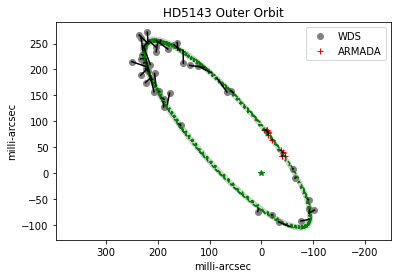

In [81]:
## Outer Orbit

fig,ax=plt.subplots()

for orbit in idx:
    tmodel = np.linspace(t_all[0],t_all[0]+2*P,1000)
    ra,dec,rapoints,decpoints = quad_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                            inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                            P2_chain[orbit],T2_chain[orbit],
                                            a3_chain[orbit],e3_chain[orbit],
                                            inc3_chain[orbit],w3_chain[orbit],bigw3_chain[orbit],
                                            P3_chain[orbit],T3_chain[orbit],t_all,tmodel)
    ra2,dec2,rapoints2,decpoints2 = orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],t_all,tmodel)
    
    ax.plot(ra, dec, '--',color='lightgrey')

tmodel = np.linspace(t_all[0],t_all[0]+2*P,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS',color='grey')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'*', label='ARMADA-VLTI',color='red')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'+', label='ARMADA-CHARA',color='blue')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='red')
ax.plot(0,0,'*',color='g')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_outer_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

Scale for triple =  1


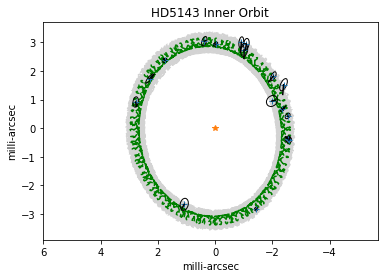

0.14699727575467597


In [83]:
# plot inner wobble
#idx = np.where(error_maj/scale<1)

fig,ax=plt.subplots()

for orbit in idx:
    tmodel = np.linspace(t[0],t[0]+4*P3_best,1000)
    ra,dec,rapoints,decpoints = quad_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                            inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                            P2_chain[orbit],T2_chain[orbit],
                                            a3_chain[orbit],e3_chain[orbit],
                                            inc3_chain[orbit],w3_chain[orbit],bigw3_chain[orbit],
                                            P3_chain[orbit],T3_chain[orbit],t_all,tmodel)
    ra2,dec2,rapoints2,decpoints2 = orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],t_all,tmodel)
    
    ra_inner = ra - ra2
    dec_inner = dec - dec2
    
    ax.plot(ra_inner, dec_inner, '--',color='lightgrey',zorder=0)

tmodel = np.linspace(t[0],t[0]+4*P3_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g',zorder=0)

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black',zorder=1)
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_inner_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

resids_x = xpos_inner[:len(xpos)] - rapoints_inner[:len(xpos)]
resids_y = ypos_inner[:len(xpos)] - decpoints_inner[:len(xpos)]
resids = np.sqrt(resids_x**2 + resids_y**2)
print(np.nanmedian(resids))

Scale for triple =  1


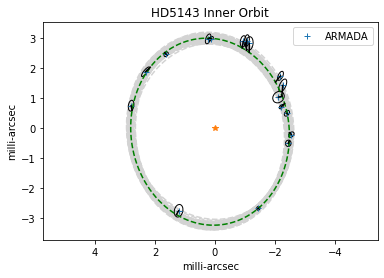

In [84]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)
fig,ax=plt.subplots()

for orbit in idx:
    tmodel = np.linspace(t[0],t[0]+P3_best,1000)
    ra,dec,rapoints,decpoints = quad_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                            inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                            P2_chain[orbit],T2_chain[orbit],
                                            a3_chain[orbit],e3_chain[orbit],
                                            inc3_chain[orbit],w3_chain[orbit],bigw3_chain[orbit],
                                            P3_chain[orbit],T3_chain[orbit],t_all,tmodel)
    ra2,dec2,rapoints2,decpoints2 = orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],t_all,tmodel)
    ra3,dec3,rapoints3,decpoints3 = orbit_model(a2_chain[orbit],e2_chain[orbit],inc2_chain[orbit],
                                            w2_chain[orbit],bigw2_chain[orbit],P2_chain[orbit],
                                            T2_chain[orbit],t_all,tmodel)

    ra_inner = ra - ra2 - ra3
    dec_inner = dec - dec2 - dec3
    ax.plot(ra_inner, dec_inner, '--',color='lightgrey',zorder=0)

tmodel = np.linspace(t[0],t[0]+P3_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(a2_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t_all,tmodel)

ra_inner = ra - ra2 - ra3
dec_inner = dec - dec2 - dec3
rapoints_inner = rapoints - rapoints2 - rapoints3
decpoints_inner = decpoints - decpoints2 - decpoints3

xpos_inner = xpos_all - rapoints2 - rapoints3
ypos_inner = ypos_all - decpoints2 - decpoints3

if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_inner1_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

Scale for triple =  1


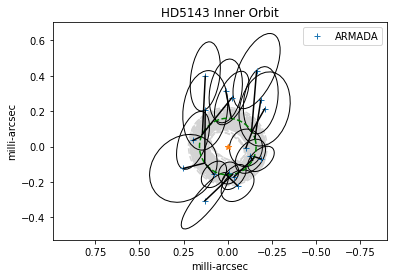

In [85]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

fig,ax=plt.subplots()
for orbit in idx:
    tmodel = np.linspace(t[0],t[0]+P2_best,1000)
    ra,dec,rapoints,decpoints = quad_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                            inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                            P2_chain[orbit],T2_chain[orbit],
                                            a3_chain[orbit],e3_chain[orbit],
                                            inc3_chain[orbit],w3_chain[orbit],bigw3_chain[orbit],
                                            P3_chain[orbit],T3_chain[orbit],t_all,tmodel)
    ra2,dec2,rapoints2,decpoints2 = orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],t_all,tmodel)
    ra3,dec3,rapoints3,decpoints3 = orbit_model(a3_chain[orbit],e3_chain[orbit],inc3_chain[orbit],
                                            w3_chain[orbit],bigw3_chain[orbit],P3_chain[orbit],
                                            T3_chain[orbit],t_all,tmodel)
    
    ra_inner = ra - ra2 - ra3
    dec_inner = dec - dec2 - dec3
    ax.plot(ra_inner, dec_inner, '--',color='lightgrey',zorder=0)

tmodel = np.linspace(t[0],t[0]+P2_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(a3_best,e3_best,inc3_best,
                                        w3_best,bigw3_best,P3_best,
                                        T3_best,t_all,tmodel)

ra_inner = ra - ra2 - ra3
dec_inner = dec - dec2 - dec3
rapoints_inner = rapoints - rapoints2 - rapoints3
decpoints_inner = decpoints - decpoints2 - decpoints3

xpos_inner = xpos_all - rapoints2 - rapoints3
ypos_inner = ypos_all - decpoints2 - decpoints3

if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_inner2_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()